In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import beta
from scipy.special import beta as beta_point
import math
import random

%matplotlib inline

Valuing customer bases accurately has been a huge problem for many business and banks. While there are many approaches, this notebook will describe the method described in [this](https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_jim_07.pdf) article by Pete Fader and Bruce Hardie.

The motivation for using this approach comes from the over reliance on fitting generic equations (like polynomicals, logarithms, and lines) to customer survival curves and using the, to preict the future value of a companies customer base. One of the biggest problems with this is that it totally ignores heterogentity in customer bases. By ignoring heterogeneity can result in significant undervaluation of customer bases, outlined in more detail in [this](http://www.brucehardie.com/papers/022/fader_hardie_mksc_10.pdf) article (see page 89 for a good visualization of this undervaluation). Instead of using generic functions, in the article linked earlier, Fader and Hardie advocate to fit a distribution to model a customers propensity to churn, which will end up better account for customer heterogeneity (especially in a temporal setting).

There are two main cases which we have to account for, where we can observer the "death" of customers, or not. This can be thought of as contractual or non-contractural settings. First, we will investigate the contractual setting, and then move on to the non-contractual setting to show how fitting statistic distributions to churn data can be significanlty more accurate than other methods.

I initially learned this methedology in MKT426 at the Universtiy of Michigan Ross School of Business, taught by Prof. Eric Schwartz.

# Contractual Setting Valuation

First, we start in the contractual setting. In this case, we can observe when a customer "dies" based on when they stop renewing their contract. These are mainly reflected by subscription companies like Blue Apron, Hello Fresh, Netflix, and others.

In performing the analysis in this (and any other application of this methedology), it is important to split customers up into "cohorts" of customers that were acquired at the same time. For our purposes, we will assume that cohorts appear at discrete units in time (for instance, all customers gained in March are one cohort and they all started on March 1st).

## Data Setup

The data stored in survival_perc is the survival percent of a real cohort of Blue Apron customers gained at time t = 0. For instance, the first element in the array is 100% because all customers are surviving, at t = 1 the survival percent is 64.3% indicating a churn rate of 1 - .643 or .357 (35.7%).

We also define a number of other valuable metrics indlucde the cost to acquire a customer, on average, the average margin per order, and a discount rate.

In [2]:
survival_perc = [100.0, 64.3, 50.2, 41.5, 35.6, 31.1, 28.2, 25.4, 23.1, 21.0, 19.5, 19.5, 17.9]

CAC = 100 # Customer Acquisition Cost
AOR = 1.8  # Average Order Rate
RPO = 57.3 # Revenue per Order
CM = .26 # Contribution Margin
M = AOR * RPO * CM # Total Margin
WACC = 0.0153 # Discount Rate

## Data Imputation

First, we impute value indicative of the "ground truth" and add markers for time.

In [3]:
# We convert the values to percents
St_actual = list(map(lambda x : x / 100, survival_perc))
# Get the total number of periods being evaluated.
T = len(St_actual)
# Calculate retention rate, defined as S(t) / S(t - 1). This is indicative of the percent of customers that were retained from period t - 1 to t.
Rt_actual = [i / j for i, j in zip(St_actual[1:T], St_actual[0:(T-1)])]
# Create a dataframe of the ground truth, Rt_actual is None in period 0 because the cohort is brand new.
d = pd.DataFrame({
    "month": range(1, T + 1), 
    "St_actual": St_actual, 
    "Rt_actual": [None] + Rt_actual
})
# Define the length of the calibration period, periods 0 - 6 will be the "trian" set and 7 - 12 will be the test set
t_calib = 6


## Geometric Model

To show the value of using a Beta distribution in evaluating customer churn and value, we first show the problems with a standard geometric model (which is also known as an exponential decay model).

### Function Definitions

In [6]:
def G_rt_sse(logit_theta: float, d: pd.DataFrame) -> float:
    """
    Calculate Sum-of-Squared errors against the DataFrame d given a specific theta.

    @param logit_theta: The theta to calculate sse with passed in logathirmically.
    @param d: A ground truth DataFrame with a column Rt_actual, aginst which sse will be calculated.
    @returns: The sse for the geometric model, defined by theta, against DataFrame d.
    """
    # Inverse log to get raw theta
    theta = 1 / (1 + pow(-logit_theta, math.e))
    # Calculate sse for the geometric function
    return sum(np.power((1 - theta) - d["Rt_actual"].iloc[1:],2))

# Defining point calculations for the geometric model
G_survival = lambda gamma, delta, t: (1 - (gamma / (gamma + delta)))^t
G_churn = lambda gamma, delta, t: (gamma / (gamma + delta)) * G_survival(gamma, delta, t - 1)

### Calibration

Here we calibrate the geometric model by minimizing sse of the geometric model, calculated with via the function G_rt_sse.

In [7]:
# Minimize SSE, assuming theta starts at .1.
theta = minimize(G_rt_sse, math.log(.1 / (1 - .1)), d[0:t_calib + 1])
# De-normalize theta to get raw theta value of the geometric function
geom_theta_nls = 1 / (1 + pow(-theta["x"][0], math.e))

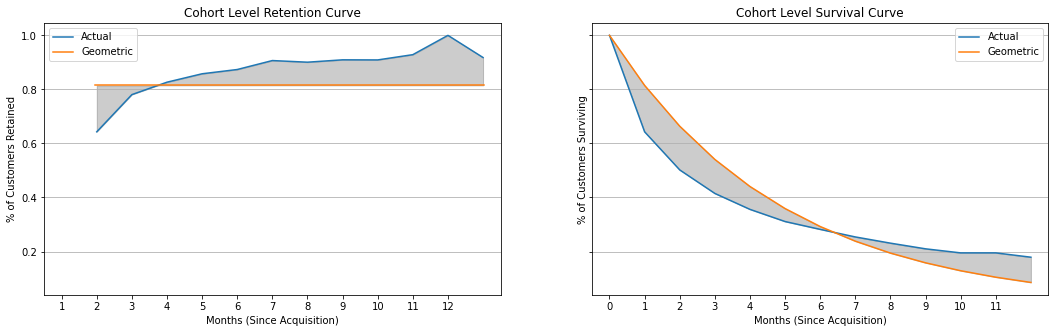

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(18, 5))

ax1.plot(d["month"], d["Rt_actual"], label = "Actual")
ax1.axhline(1-geom_theta_nls, xmin = 1.5/13.5, xmax = 13/13.5, color = "C1", label="Geometric")
ax1.fill_between(d["month"], d["Rt_actual"], 1 - geom_theta_nls, color = (0,0,0,0.2))
ax1.set_xlim(0.5, 13.5)
ax1.set_xticks(range(1, 13))
ax1.grid(axis = "y")
ax1.set_title("Cohort Level Retention Curve")
ax1.set_ylabel("% of Customers Retained")
ax1.set_xlabel("Months (Since Acquisition)")
ax1.legend()

ax2.plot(d.index, d["St_actual"], label="Actual")
ax2.plot(d.index, np.power(1 - geom_theta_nls, range(0, T)), label="Geometric")
ax2.fill_between(d.index, d["St_actual"], np.power(1 - geom_theta_nls, range(0, T)), color = (0,0,0,0.2))
ax2.set_xlim(-0.5, 12.5)
ax2.set_xticks(range(0, 12))
ax2.grid(axis = "y")
ax2.set_title("Cohort Level Survival Curve")
ax2.set_ylabel("% of Customers Surviving")
ax2.set_xlabel("Months (Since Acquisition)")
ax2.legend()

Here we see that a geometric model assumes a constant retention rate (and likewise a constant churn rate), which the graph indicates is obviously not correct. Looking at the Cohort Level Survival Curve we can see the usual story with this model where it under-predicts churn in the early periods and over-estimates churn in the later periods. Why is this?

## Beta Geometric Model

After showing the inaccuracy of the geometric model, now let us investigate the significnat improvements a beta geometric model can offer.

### Function Definitions

In [132]:
def BG_rt(gamma: float, delta: float, t: int) -> float: 
    """
    Calculate the retention time t for a beta-geometric model described by gamma delta.
    
    @param gamma: The gamma parameter of the beta-geometric function.
    @param delta: The delta parameter of the beta-geometric function.
    @param t: The time at which to calculate retention.
    @returns: The retention rate at time t for BG(G, D)
    """
    return ((delta + t - 1) / (gamma + delta + t - 1))

def BG_rt_sse(params: list, d: pd.DataFrame) -> float:
    """
    Calculate sum-of-Squared errors against the DataFrame d given a beta-geomtric model defined by gamma and delta.

    @param params: A list of 2 floats list params[0] being gamma and params[1] being delta.
    @param d: A ground truth DataFrame with a column Rt_actual, aginst which sse will be calculated.
    @returns: The sse for the geometric model, defined by params, against DataFrame d.
    """
    # Un-normalize gamma and delta to raw values
    gamma = pow(params[0], math.e)
    delta = pow(params[1], math.e)
    # Get the values of all the allowable values to calculate sse for
    t = d.index[1:]
    Rt_actual = d["Rt_actual"].iloc[1:]
    # Get a list of all retentions predicted by the beta geometric function defined by gamma, delta
    pred = BG_rt(gamma, delta, t)
    # Calculate sse for the beta-geometric model against dataframe d
    return sum(pow(Rt_actual - pred, 2))

# Defining point calculations for the beta geometric model
BG_churn = lambda gamma, delta, t: beta_point(gamma + 1, delta + t - 1) / beta_point(gamma, delta) 
BG_survival = lambda gamma, delta, t: beta_point(gamma, delta + t) / beta_point(gamma, delta)

# Defining More Robust Model Takeaways
def BG_clv(gamma: float, delta: float, cf: float, disc: float, cac: float, t: int = 2000) -> pd.DataFrame:
    """
    Generate valuation data from beta-geometric input statistics.

    :param gamma: Gamma statistic of the beta model
    :param delta: Delta statistics of the beta model
    :param cf: Per purchase cash flow
    :param disc: Discount rate for time-value calculations
    :param cac: Cost of acquiring a customer in t = 0
    :param t: The number of periods to predict out
    """
    
    clv = pd.DataFrame({
        'cf': cf,
        'period': range(0, t),
        'st': BG_survival(gamma, delta, range(0, t)),
        'cac': cac
    })
    # Creating various model stats
    clv['st_lag'] = clv["st"].shift(1)
    clv["rt"] = clv["st"] / clv["st_lag"]
    clv['st_lead'] = clv["st"].shift(-1)
    clv["pt"] = clv["st"] - clv["st_lead"]
    # Discounting Cashflows
    clv["disc_t"] = 1 / pow(1 + disc, clv["period"])
    clv["disc_cf"] = clv["cf"] * clv["disc_t"]
    # Cumulative: POTENTIAL discounted lifetimes and cumulative discounted cash flow values
    clv["disc_lifetime"] = np.cumsum(clv["disc_t"]) # cumulative discounting is "discounted lifetime"
    clv["expected_cumdisc_cf"] = clv["cf"] * np.cumsum(clv["disc_t"] * clv["st"]) - cac # E(CnV): expected customer value thru n periods
    clv["pav"] = round(clv["cf"] * clv["disc_lifetime"], 2) # post-acquisition value!
    clv["clv"] = round(clv["pav"] - cac, 2) # shift CLV to be actual CLV = PAV - CAC
    clv["pt_conv"] = [*clv["pt"][:-1], 1 - sum(clv["pt"][0:-1])]
    clv["e_clv"] = sum(clv["clv"] * clv["pt_conv"])
    clv["eclv_n"] = max(clv["expected_cumdisc_cf"]) - cac

    return clv

def BG_rlv(gamma: float, delta: float, cf: float, disc: float, past_t: int, t_end: int = 2000) -> pd.DataFrame:
    """
    Generate valuation data from beta-geometric input statistics after a certian time past_t.

    :param gamma: Gamma statistic of the beta model
    :param delta: Delta statistics of the beta model
    :param cf: Per purchase cash flow
    :param disc: Discount rate for time-value calculations
    :param cac: Cost of acquiring a customer in t = 0
    :param t: The number of periods to predict out
    """
    rlv = pd.DataFrame({
        'cf': cf,
        'period': range(past_t + 1, t_end + 1),
        'period_lag' : range(past_t, t_end)
    })

    rlv["st"] = BG_survival(gamma, delta, rlv["period"])
    rlv["st_past_t"] = BG_survival(gamma, delta, past_t)
    rlv["st_conditional"] = rlv["st"] / rlv["st_past_t"]
    rlv["pt_conditional"] = [1 - rlv["st_conditional"].iloc[0], *((rlv["st_conditional"] - rlv["st_conditional"].shift(-1))[0:-1])]
    rlv["discounted_RL"] = [0, *((1 / pow(1 + disc, rlv["period_lag"] - past_t - 1))[1:])]
    rlv["discounted_cf"] = rlv["cf"] * rlv["discounted_RL"]
    rlv["rlv"] = round(np.cumsum(rlv["discounted_cf"]), 2)

    rlv_sum_nest = rlv.groupby("rlv").agg({
        "rlv": ["size"],
        'pt_conditional': ["sum"]
    })

    rlv_sum = pd.DataFrame({"rlv": rlv_sum_nest.index, "num_exact_values": rlv_sum_nest["rlv"]["size"], "pt_conditional_sum": rlv_sum_nest["pt_conditional"]["sum"]})

    rlv_sum["pt_cond_conv"] = [*(rlv_sum["pt_conditional_sum"].iloc[0:-1]), 1 - sum(rlv_sum["pt_conditional_sum"].iloc[0:-1])]
    rlv_sum["erlv"] = sum(rlv_sum["rlv"] * rlv_sum["pt_cond_conv"])
    rlv_sum["past_t"] = past_t

    rlv_sum.reset_index(drop=True, inplace=True)

    return rlv_sum

### Calibration

In [8]:
preds = minimize(BG_rt_sse, (1, 1), d[0:t_calib + 1])

gamma_nls = pow(preds["x"][0], math.e)
delta_nls = pow(preds["x"][1], math.e)

### Visualization

Text(0.5, 0, 'Churn Probability: ϴ')

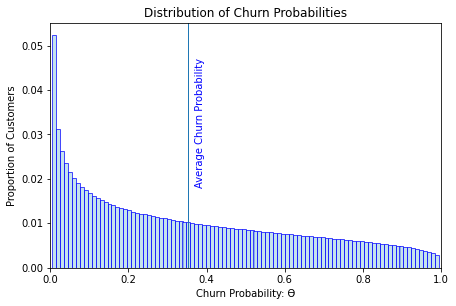

In [9]:
x = np.linspace(0, 1, 100)
m = beta.cdf(x, gamma_nls, delta_nls)
n = np.append(0, m)[:-1]
o = (m - n)[1:-1]
# TODO: Make this whole block more pythonic
lsts = {
        "p": np.linspace(0, 1, 100)[1:-1], 
        "cdf": beta.cdf(x, gamma_nls, delta_nls)[1:-1], 
        "cdf_diff": (beta.cdf(np.linspace(0, 1, 100), gamma_nls, delta_nls) - np.append(0, beta.cdf(np.linspace(0, 1, 100), gamma_nls, delta_nls))[:-1])[1:-1]
       }

data = pd.DataFrame(lsts)

fig, ax = plt.subplots(1, 1, figsize = (7, 4.5))

ax.bar(data["p"], data["cdf_diff"], width = 1/98, color = "lightblue", alpha = 0.7, edgecolor = "blue")
ax.axvline(gamma_nls / (gamma_nls + delta_nls), lw = 1)
ax.text(gamma_nls / (gamma_nls + delta_nls) * 1.05, max(data["cdf_diff"]) * 0.35, "Average Churn Probability", rotation = 90, color = "blue")
ax.set_xlim(0, 1)
ax.title.set_text("Distribution of Churn Probabilities")
ax.set_ylabel("Proportion of Customers")
ax.set_xlabel("Churn Probability: \u03F4")

In [10]:
Rt_model = [None, *BG_rt(gamma_nls, delta_nls, range(1, T))]
St_model = [1, *np.cumprod(Rt_model[1:])]

d_est = d.assign(St_model = St_model, Rt_model = Rt_model)

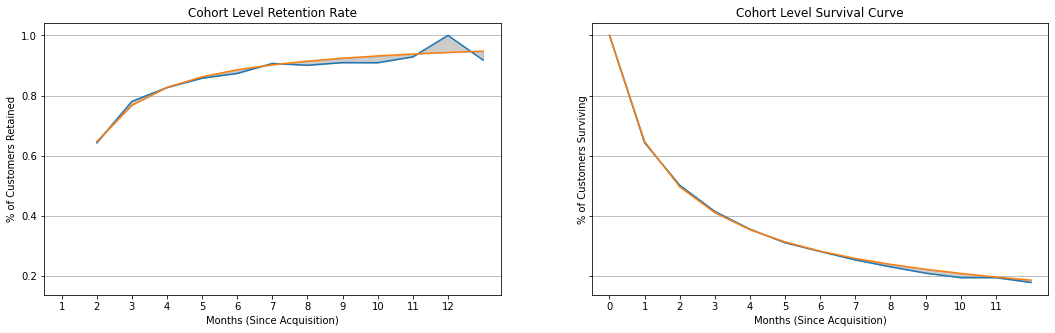

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(18, 5))

ax1.plot(d_est["month"], d_est["Rt_actual"])
ax1.plot(d_est["month"], d_est["Rt_model"])
ax1.fill_between(d_est["month"], d_est["Rt_actual"], d_est["Rt_model"], color = (0,0,0,0.2))
ax1.set_title("Cohort Level Retention Rate")
ax1.set_ylabel("% of Customers Retained")
ax1.set_xlabel("Months (Since Acquisition)")
ax1.set_xlim(0.5, 13.5)
ax1.set_xticks(range(1, 13))
ax1.grid(axis = "y")

ax2.plot(d_est.index, d_est["St_actual"])
ax2.plot(d_est.index, d_est["St_model"])
ax2.fill_between(d_est.index, d_est["St_actual"], d_est["St_model"], color = (0,0,0,0.2))
ax2.set_title("Cohort Level Survival Curve")
ax2.set_ylabel("% of Customers Surviving")
ax2.set_xlabel("Months (Since Acquisition)")
ax2.set_xlim(-0.5, 12.5)
ax2.set_xticks(range(0, 12))
ax2.grid(axis = "y")

### Value Findings

In [133]:
clv_data = BG_clv(gamma_nls, delta_nls, M, WACC, CAC)
past_t = 4
rlv_data = BG_rlv(gamma_nls, delta_nls, M, WACC, past_t)

xmax_both = max([*clv_data["clv"], *rlv_data["rlv"]])
ymax_both = max([*clv_data["pt_conv"], *rlv_data["pt_cond_conv"]])

#### CLV Distribution

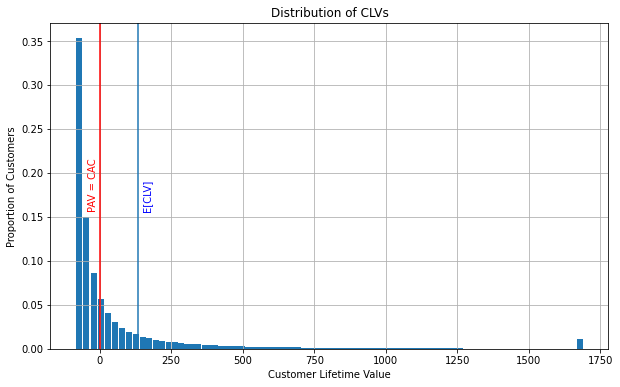

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

test = clv_data.groupby("clv")["pt_conv"].sum()

ax.bar(test.index, test, 20)
ax.axvline(0, color = "red")
ax.axvline(clv_data["e_clv"].mean())
ax.set_title("Distribution of CLVs")
ax.set_ylabel("Proportion of Customers")
ax.set_xlabel("Customer Lifetime Value")
ax.text(-40, ymax_both * 0.45, "PAV = CAC", rotation = 90, color = "red")
ax.text(clv_data["e_clv"].mean() * 1.1, ymax_both * 0.45, "E[CLV]", rotation = 90, color = "blue")
ax.grid()

#### Cohort Valuation

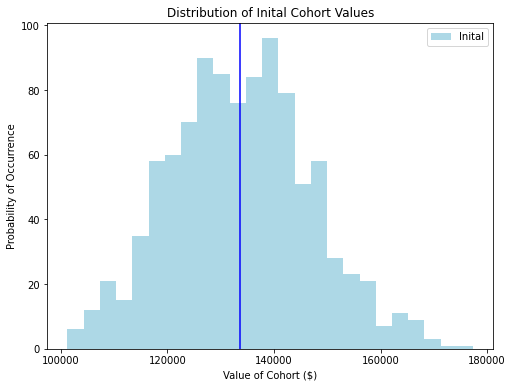

In [123]:
n_sims = 1000
n_cohort = 1000

sim_vals = pd.DataFrame([random.choices(clv_data["clv"], clv_data["pt_conv"], k = n_cohort) for _ in range(n_sims)])

cohort_sim_totals = sim_vals.sum()
cohort_sim_avg = sim_vals.mean()
cohort_sim_std = sim_vals.std()

clv_avg = clv_data["e_clv"].mean()
clv_var = clv_data["clv"].var()

cohort_calc_avg = clv_avg * n_cohort
cohort_calc_var = n_cohort * clv_var
cohort_calc_std = pow(cohort_calc_var, 0.5)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(cohort_sim_totals, bins = 25, color="lightblue", label = "Inital")
ax.axvline(cohort_calc_avg, color="blue", label = "Average Cohort Value")
ax.set_xticks([100000, 120000, 140000, 160000, 180000])
ax.set_title("Distribution of Inital Cohort Values")
ax.set_xlabel("Value of Cohort ($)")
ax.set_ylabel("Probability of Occurrence")
ax.legend()

#### Customer Timing Insights

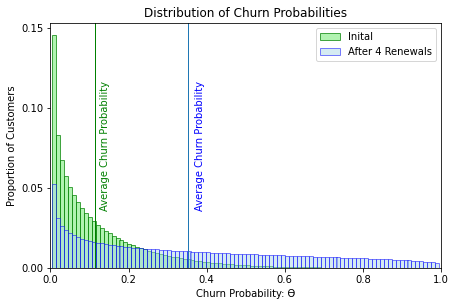

In [122]:
lsts = {
    "p": np.linspace(0, 1, 100)[1:-1],
    "cdf1": beta.cdf(x, gamma_nls, delta_nls)[1:-1],
    "cdf2": beta.cdf(x, gamma_nls, delta_nls + past_t)[1:-1],
    "cdf_diff1": (beta.cdf(np.linspace(0, 1, 100), gamma_nls, delta_nls) - np.append(0, beta.cdf(np.linspace(0, 1, 100), gamma_nls, delta_nls))[:-1])[1:-1],
    "cdf_diff2": (beta.cdf(np.linspace(0, 1, 100), gamma_nls, delta_nls + past_t) - np.append(0, beta.cdf(np.linspace(0, 1, 100), gamma_nls, delta_nls + past_t))[:-1])[1:-1]
}

data = pd.DataFrame(lsts)

fig, ax = plt.subplots(1, 1, figsize = (7, 4.5))

ax.bar(data["p"], data["cdf_diff2"], width = 1/98, color = "lightgreen", alpha = 0.7, edgecolor = "green", label="Inital")
ax.bar(data["p"], data["cdf_diff1"], width = 1/98, color = "lightblue", alpha = 0.5, edgecolor = "blue", label = "After 4 Renewals")
ax.axvline(gamma_nls / (gamma_nls + delta_nls), lw = 1)
ax.text(gamma_nls / (gamma_nls + delta_nls) * 1.05, max(data["cdf_diff1"]) * 0.7, "Average Churn Probability", rotation = 90, color = "blue")
ax.axvline(gamma_nls / (gamma_nls + delta_nls + past_t), lw = 1, color = "green")
ax.text(gamma_nls / (gamma_nls + delta_nls + past_t) * 1.1, max(data["cdf_diff1"]) * 0.7, "Average Churn Probability", rotation = 90, color = "green")
ax.set_xlim(0, 1)
ax.title.set_text("Distribution of Churn Probabilities")
ax.set_ylabel("Proportion of Customers")
ax.set_xlabel("Churn Probability: \u03F4")
ax.set_yticks([0.0, 0.05, 0.1, 0.15])
ax.legend()

<BarContainer object of 2001 artists>

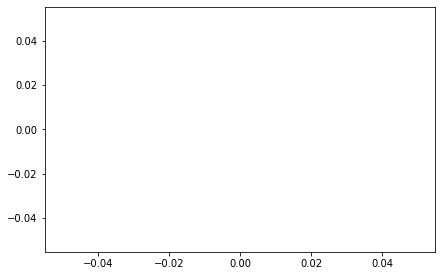

In [140]:
merged = rlv_data.merge(clv_data, left_on = "rlv", right_on = "pav", how="left")

fig, ax = plt.subplots(1, 1, figsize = (7, 4.5))

ax.bar(merged["pav"], merged["pt_conv"], width = 20, color = "lightblue", alpha = 0.5, edgecolor = "blue", label = "Inital")
ax.bar(merged["rlv"], merged["pt_cond_conv"], width = 20, color = "lightgreen", alpha = 0.5, edgecolor = "green", label = "After 4 Renewals")